<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/Trend_and_Volume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trend and Volume 

I suspect there's a relationship between trend and volume.

For example, if a shitcoin "breaks out" on more volume is that more meaningful than if it breaks out on less volume?

Lets investigate.


In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'roll', 'tibbletime'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpYfXrxw/remotes7b58a782c8/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



# What data do we want?

* Perp prices
* Perp funding rates

In [2]:
rwlab_data_auth()

Authorization successful!

In [3]:
# snippet: rw crypto load ftx futures v0.1
futures <- rwRtools::crypto_get_futures()

futures %>% 
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

# snippet: rw crypto load ftx perpetual funding rates v0.1
perp_rate <- rwRtools::crypto_get_perp_rates()

perp_rate %>%
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 232.4…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-07-20 12:00:00,2022-11-12


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-03-06 15:00:00,2022-11-12


# Join price and yields data

In [4]:
perp_rate %>% head()

ticker,date,rate
<chr>,<dttm>,<dbl>
1INCH-PERP,2020-12-25 03:00:00,0.000000
1INCH-PERP,2020-12-25 04:00:00,0.000000
1INCH-PERP,2020-12-25 05:00:00,0.000000
1INCH-PERP,2020-12-25 06:00:00,0.000558
1INCH-PERP,2020-12-25 07:00:00,0.000120
1INCH-PERP,2020-12-25 08:00:00,0.000123


In [5]:
universe <- futures %>% 
  inner_join(perp_rate, by = c('ticker','date')) 

universe %>% head()

ticker,date,open,high,low,close,volume,rate
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1INCH-PERP,2020-12-25 05:00:00,2.38335,3.1132,2.2866,2.5700,2970965,0.000000
1INCH-PERP,2020-12-25 06:00:00,2.57000,2.6621,2.2278,2.5112,2220601,0.000558
1INCH-PERP,2020-12-25 07:00:00,2.51010,2.8200,2.3660,2.6334,2654891,0.000120
1INCH-PERP,2020-12-25 08:00:00,2.63340,2.8020,2.4711,2.6150,3450362,0.000123
1INCH-PERP,2020-12-25 09:00:00,2.61500,2.7300,2.5733,2.6403,1680502,0.000023
1INCH-PERP,2020-12-25 10:00:00,2.64030,2.9613,2.6270,2.7793,3842093,0.000078


## Calculate log returns

The "rate" is the funding rate, which is the rate that shorts would receive at the beginning of each hour.

To make the data easier to work, with let's assume that the funding event happens at the end of the previous hour. 

That lets us calculate returns from:
 * price change
 * funding accrual
 * total return.

Which we can work with easily

In [6]:
universe <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    m2m_returns_simple = close/lag(close, 1) - 1,
    m2m_returns_log = log(m2m_returns_simple + 1),
    funding_returns_simple = lead(-rate),
    funding_returns_log = log(funding_returns_simple + 1),
    total_returns_simple = m2m_returns_simple + funding_returns_simple,
    total_returns_log = log(total_returns_simple + 1)
  ) %>% 
  na.omit()

universe %>% head()

ticker,date,open,high,low,close,volume,rate,m2m_returns_simple,m2m_returns_log,funding_returns_simple,funding_returns_log,total_returns_simple,total_returns_log
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALGO-PERP,2019-07-20 13:00:00,0.7161,0.7257,0.7014,0.7054,2.657606e+03,0.000003,-0.0149420472,-0.0150548042,0.000011,1.099994e-05,-0.0149310472,-0.0150436374
ALT-PERP,2019-07-20 13:00:00,764.8000,775.5000,760.5000,763.9000,0.000000e+00,0.000010,-0.0011767782,-0.0011774712,-0.000007,-7.000025e-06,-0.0011837782,-0.0011844795
BCH-PERP,2019-07-20 13:00:00,316.2000,321.1500,312.2000,314.8500,8.144407e+02,-0.000108,-0.0042694497,-0.0042785898,0.000126,1.259921e-04,-0.0041434497,-0.0041520576
BNB-PERP,2019-07-20 13:00:00,30.6250,30.8675,30.3350,30.5625,1.649716e+05,0.000054,-0.0020408163,-0.0020429016,-0.000030,-3.000045e-05,-0.0020708163,-0.0020729634
BSV-PERP,2019-07-20 13:00:00,167.1000,173.3800,166.6000,168.1200,7.331051e+04,0.000009,0.0061041293,0.0060855745,-0.000005,-5.000013e-06,0.0060991293,0.0060806049
BTC-PERP,2019-07-20 13:00:00,10539.5000,10796.2500,10477.0000,10548.7500,2.361670e+07,-0.000003,0.0008776507,0.0008772658,-0.000003,-3.000004e-06,0.0008746507,0.0008742685


## Apply universe criteria

* Remove price less than 0.01
* Require to be in top 70% by volume traded

In [7]:
universe <- universe %>% 
  mutate(
    is_universe_price = min(open, high, low, close) >= 0.01,
    trail_volume = roll_mean(volume, 30 * 24)
  ) %>%
  na.omit() %>%
  group_by(date) %>%
  mutate(
    volume_decile = ntile(trail_volume, 10),
    is_universe_volume = volume_decile >= 3,
    is_universe = is_universe_price & is_universe_volume
  )

In [8]:
universe %>% head()

ticker,date,open,high,low,close,volume,rate,m2m_returns_simple,m2m_returns_log,funding_returns_simple,funding_returns_log,total_returns_simple,total_returns_log,is_universe_price,trail_volume,volume_decile,is_universe_volume,is_universe
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<int>,<lgl>,<lgl>
ALGO-PERP,2019-08-19 14:00:00,0.67260,0.67280,0.66680,0.6671,55678.89620,0.000055,-0.0081772227,-0.0082108396,-0.000057,-5.700162e-05,-0.0082342227,-0.0082683112,TRUE,44786.91,8,TRUE,TRUE
ALT-PERP,2019-08-19 14:00:00,668.30000,669.30000,666.30000,667.9000,170478.97730,-0.000013,-0.0005985336,-0.0005987128,0.000020,1.999980e-05,-0.0005785336,-0.0005787010,TRUE,17448.99,3,TRUE,TRUE
BCH-PERP,2019-08-19 14:00:00,324.90000,326.25000,323.50000,325.7000,12990.95705,0.000028,0.0024622961,0.0024592696,-0.000029,-2.900042e-05,0.0024332961,0.0024303404,TRUE,16473.88,2,FALSE,FALSE
BNB-PERP,2019-08-19 14:00:00,28.88500,28.90500,28.79750,28.8625,57755.00000,-0.000131,-0.0007789510,-0.0007792546,0.000158,1.579875e-04,-0.0006209510,-0.0006211439,TRUE,38724.42,7,TRUE,TRUE
BSV-PERP,2019-08-19 14:00:00,143.26000,144.76000,143.26000,144.1300,0.00000,0.000029,0.0060728745,0.0060545089,-0.000036,-3.600065e-05,0.0060368745,0.0060187256,TRUE,51616.77,9,TRUE,TRUE
EOS-PERP,2019-08-19 14:00:00,3.73825,3.75825,3.73225,3.7500,11.22975,0.000000,0.0031431820,0.0031382525,0.000008,7.999968e-06,0.0031511820,0.0031462274,TRUE,20944.59,4,TRUE,TRUE


# Resample to daily to make it easier to work with

In [9]:
daily <- universe %>% 
  mutate(
    datetime = date,
    date = as_date(date)
  ) %>%
  group_by(date, ticker) %>%
  arrange(datetime) %>% 
  summarize(
    open = first(open),
    high = max(high),
    low = min(low),
    close = last(close),
    volume = sum(volume),
    trail_volume = last(trail_volume),
    m2m_returns_log = sum(m2m_returns_log),
    m2m_returns_simple = exp(m2m_returns_log) - 1,
    funding_returns_log = sum(funding_returns_log),
    funding_returns_simple = exp(funding_returns_log) - 1,
    total_returns_simple = m2m_returns_simple + funding_returns_simple,
    total_returns_log = log(total_returns_simple + 1),
    is_universe = sum(is_universe) > 0
  )  %>%
  # Calculate relative returns
  group_by(date) %>%
  mutate(
    total_relative_returns = total_returns_log - mean(total_returns_log)
  ) %>%
  # Calculate cumulative total return series for these shitcoins
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(cum_total_returns = cumsum(total_returns_log))

daily %>% head()

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `total_returns_log = log(total_returns_simple + 1)`.
ℹ In group 111899: `date = 2022-11-10`, `ticker = "ASD-PERP"`.
Caused by warning in `log()`:
! NaNs produced”
`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


date,ticker,open,high,low,close,volume,trail_volume,m2m_returns_log,m2m_returns_simple,funding_returns_log,funding_returns_simple,total_returns_simple,total_returns_log,is_universe,total_relative_returns,cum_total_returns
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
2019-08-19,ALGO-PERP,0.6726,0.6728,0.6561,0.6563,62951.81,44787.94,-0.024532798,-0.024234315,-0.0006130194,-0.0006128315,-0.0248471461,-0.0251610471,TRUE,-0.0249045189,-0.0251610471
2019-08-19,ALT-PERP,668.3000,669.8000,653.6000,667.6000,200431.11,17489.16,-0.001047983,-0.001047434,0.0002909954,0.0002910377,-0.0007563961,-0.0007566823,TRUE,-0.0005001541,-0.0007566823
2019-08-19,BCH-PERP,324.9000,326.4000,318.2500,325.3500,81431.32,16506.84,0.001384083,0.001385042,-0.0002690042,-0.0002689680,0.0011160736,0.0011154512,FALSE,0.0013719794,0.0011154512
2019-08-19,BNB-PERP,28.8850,29.0225,28.4250,28.8225,519170.14,39071.96,-0.002166097,-0.002163753,0.0005459375,0.0005460865,-0.0016176663,-0.0016189761,TRUE,-0.0013624480,-0.0016189761
2019-08-19,BSV-PERP,143.2600,145.9400,142.0500,145.6200,63454.36,49623.70,0.016339328,0.016473545,-0.0001870029,-0.0001869854,0.0162865592,0.0161553559,TRUE,0.0164118840,0.0161553559
2019-08-19,BTC-PERP,10741.0000,10945.5000,10645.2500,10930.7500,40979263.38,4719288.59,0.017511724,0.017665953,-0.0002450040,-0.0002449740,0.0174209789,0.0172709733,TRUE,0.0175275015,0.0172709733


# Hypothesis 

* High volume move = more likely to continue
* Low volume move = more likely to move

Last time we looked at a "breakout" feature (recency of 20 day high) - let's use that again because it's nice and well behaved.

In [10]:
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 20, na_value = NA), 
  otherwise = NA
)

features <- daily %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    breakout = lag(9.5 - rolling_days_since_high_20(close)),
    breakout_tr = lag(9.5 - rolling_days_since_high_20(total_returns_log)),
    carry = lag(funding_returns_log),
    volume1 = lag(volume),
    volume3 = lag(roll_mean(volume,3)),
    volume30 = lag(trail_volume),
    volumez20 = lag((volume - roll_mean(volume,20)) / roll_sd(volume,20)),
    volumez3z20 = lag((roll_mean(volume,3) - roll_mean(volume,20)) / roll_sd(volume,20)),
    volumez5z20 = lag((roll_mean(volume,5) - roll_mean(volume,20)) / roll_sd(volume,20))
  ) %>%
  # Relative Features
  group_by(date) %>%
  mutate(
    breakout_rel = ntile(breakout, 10),
    breakout_tr_rel = ntile(breakout_tr, 10),
    carry_rel = ntile(carry, 10),
    volume30_rel = ntile(volume30, 10)
  ) %>%
  na.omit()

Quick check that feature explains some variance

In [11]:
features %>%
  ungroup() %>%
  filter(is_universe) %>%
  summarize(
    breakout_IC = cor(breakout, total_returns_log),
    breakout_rel_IC = cor(breakout, total_relative_returns),
    breakout_rel_rel_IC = cor(breakout_rel, total_relative_returns)
  )

breakout_IC,breakout_rel_IC,breakout_rel_rel_IC
<dbl>,<dbl>,<dbl>
0.007175196,0.0008696963,-0.003912952


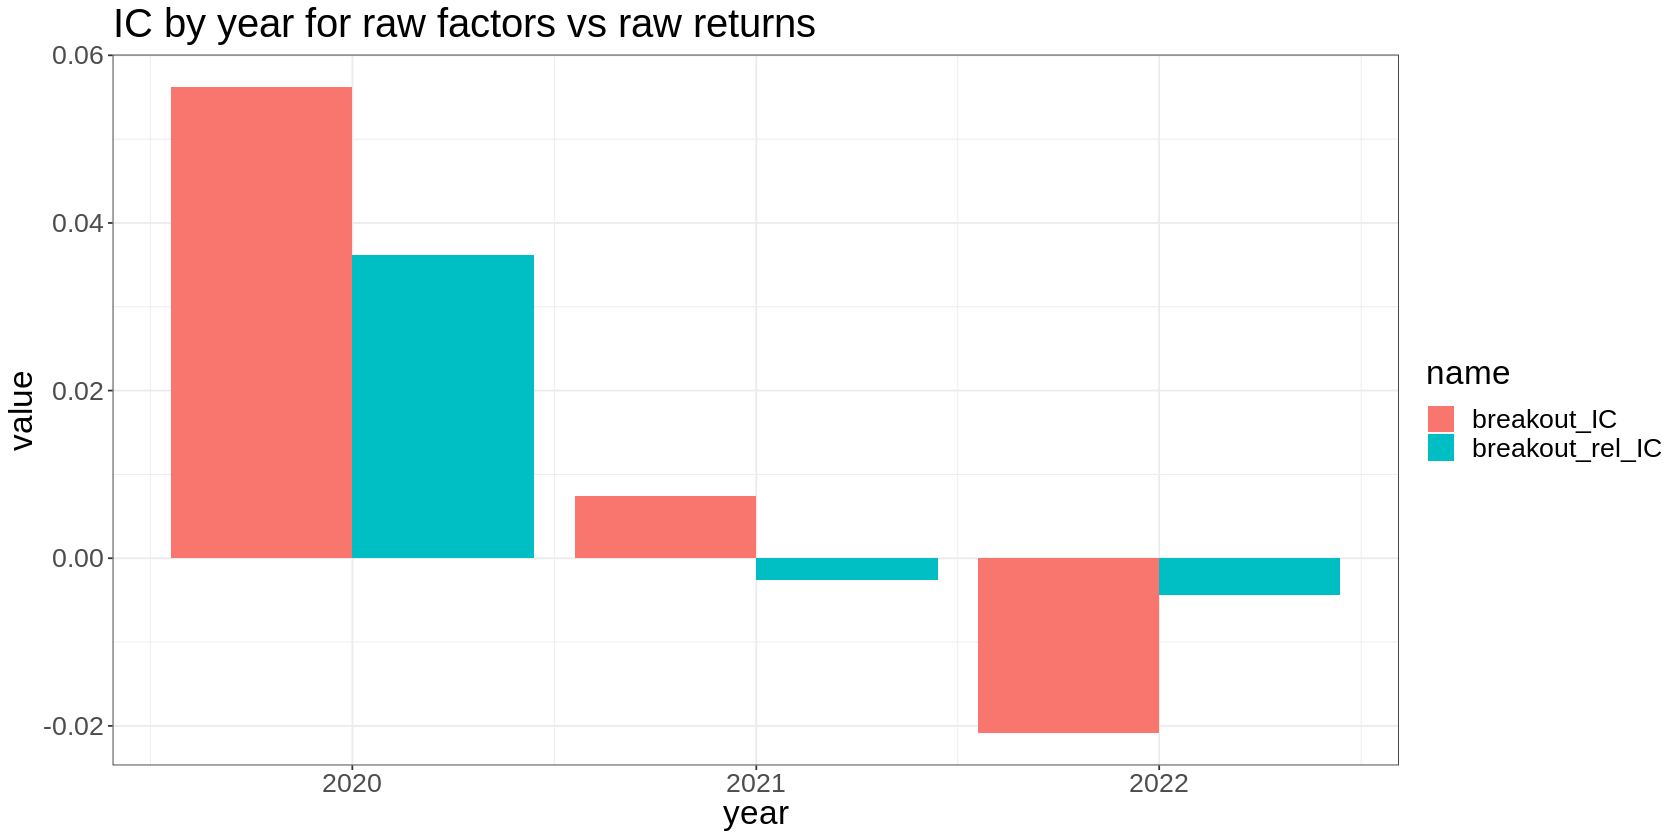

In [12]:
features %>%
  mutate(year = floor_date(date, 'year')) %>%
  filter(year > '2019-01-01') %>% #hardly any data
  group_by(year) %>%
  filter(is_universe) %>%
  summarize(
    breakout_IC = cor(breakout, total_returns_log),
    breakout_rel_IC = cor(breakout, total_relative_returns)
  ) %>% 
  pivot_longer(-year) %>%
  ggplot(aes(x=year, y=value, fill=name)) + geom_bar(stat='identity', position = 'dodge') + ggtitle('IC by year for raw factors vs raw returns')

Our breakout feature isn't a good predictor of relative returns.


# Look at information coefficient conditional on 30d volume, ranked each day.

Does the feature explain returns better if there is more trading over the 20d window.

Let's look as this shit, conditional on 30d volume.

Note, I wouldn't really expect to see anything here... cos that's the volume over the whole period we're looking at, not the crucial bit at the end of range.

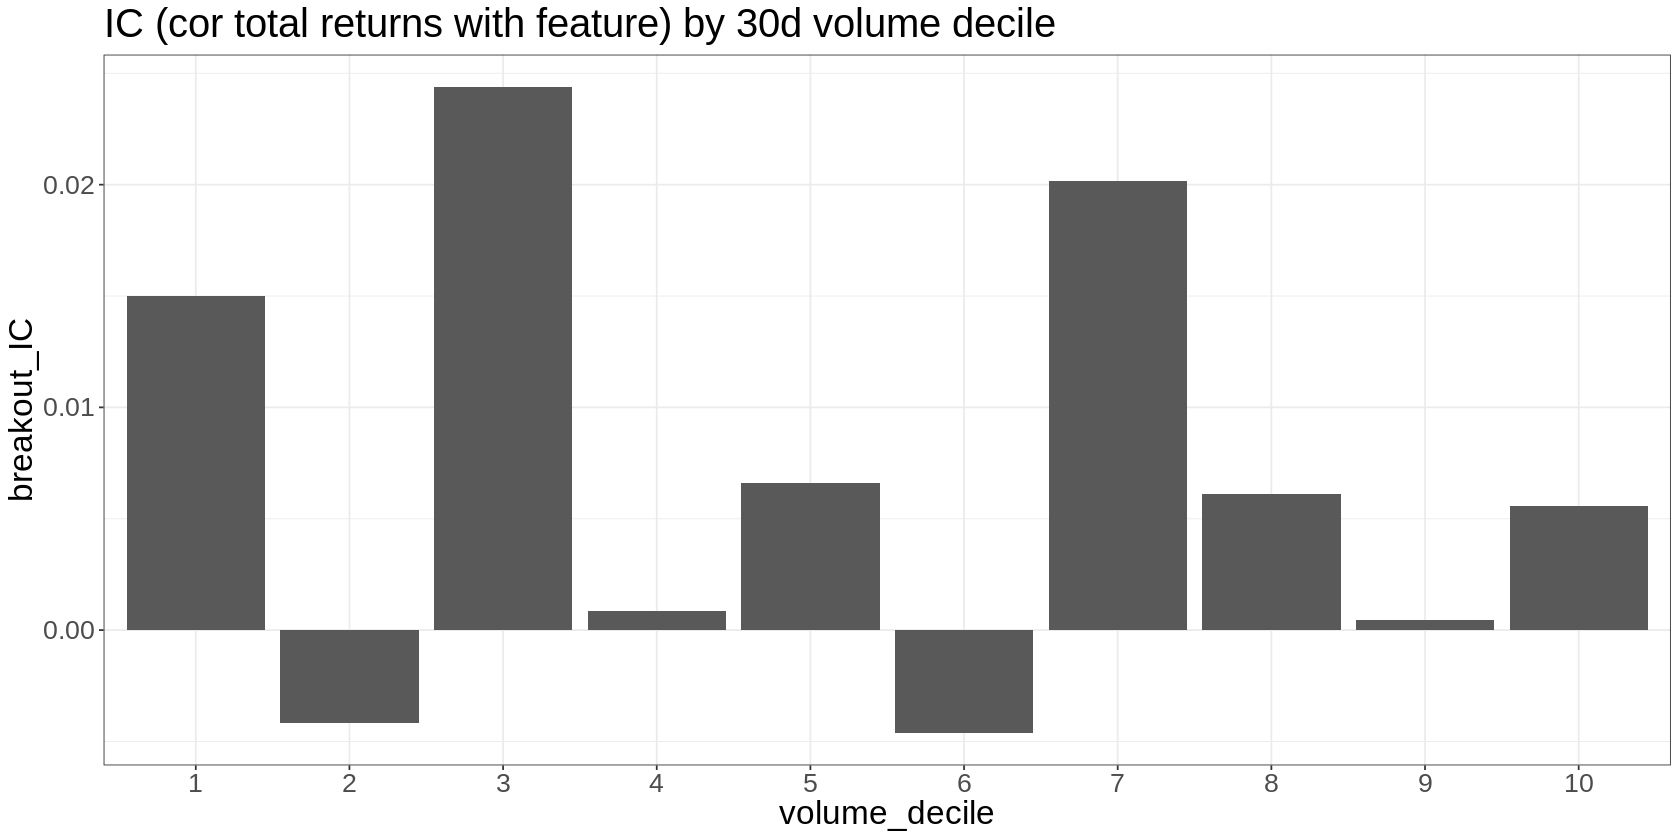

In [13]:
features %>% 
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(volume_decile = factor(ntile(volume30, 10))) %>%
  group_by(volume_decile) %>%
  summarize(breakout_IC = cor(breakout, total_returns_log)) %>%
  ggplot(aes(x=volume_decile, y=breakout_IC)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('IC (cor total returns with feature) by 30d volume decile')

What about if we forgot about sorting by date, did it for everything?

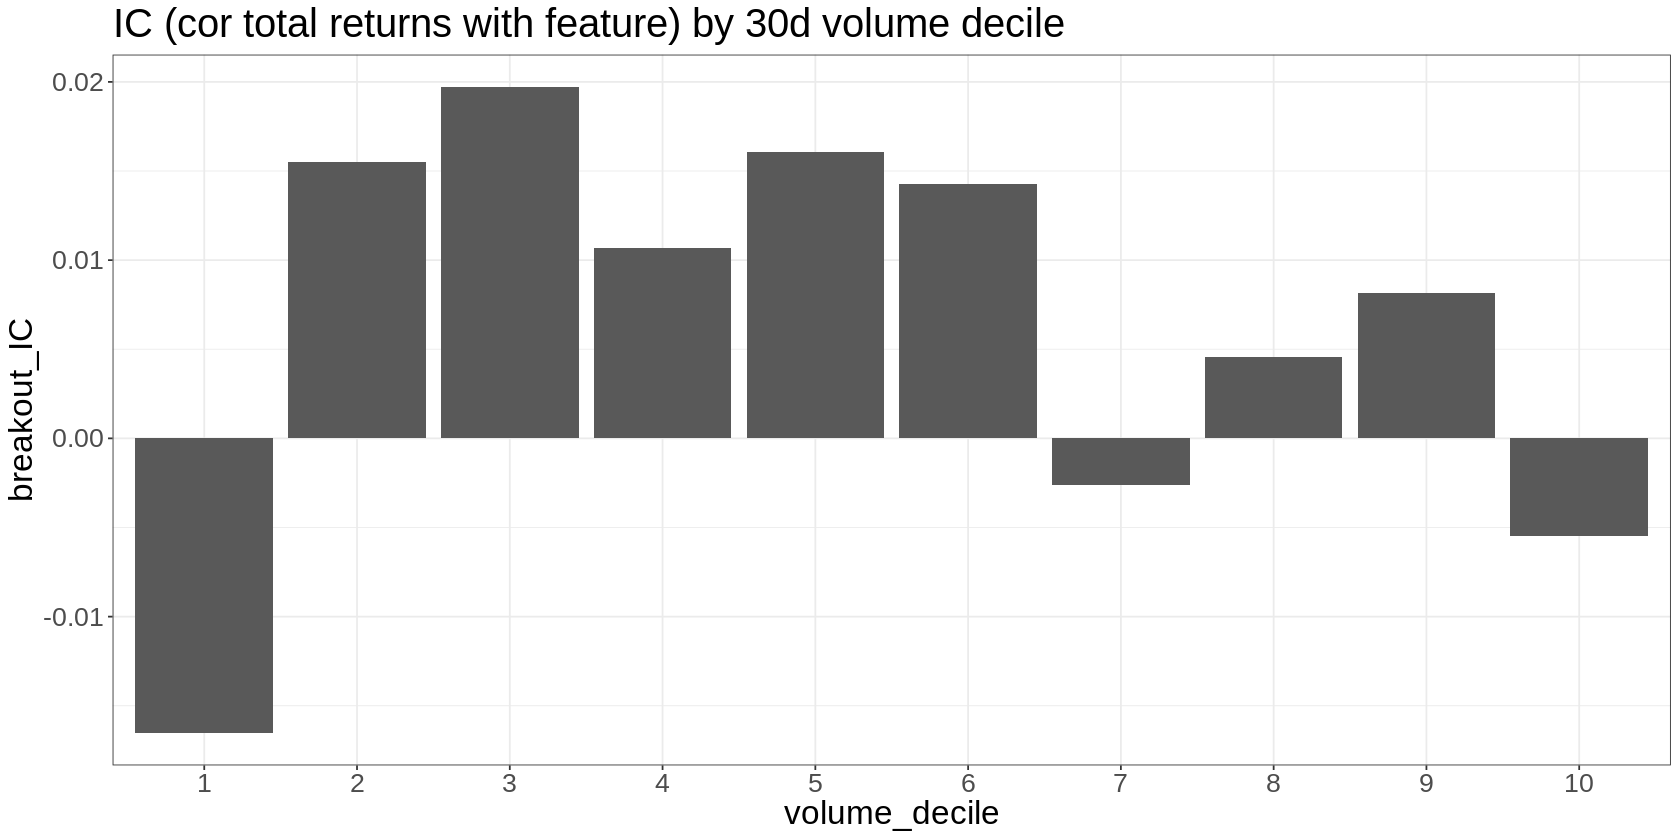

In [14]:
features %>% 
  filter(is_universe) %>%
  ungroup() %>%
  mutate(volume_decile = factor(ntile(volume30, 10))) %>%
  group_by(volume_decile) %>%
  summarize(breakout_IC = cor(breakout, total_returns_log)) %>%
  ggplot(aes(x=volume_decile, y=breakout_IC)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('IC (cor total returns with feature) by 30d volume decile')

Still meh. What if we just pulled out BTC?

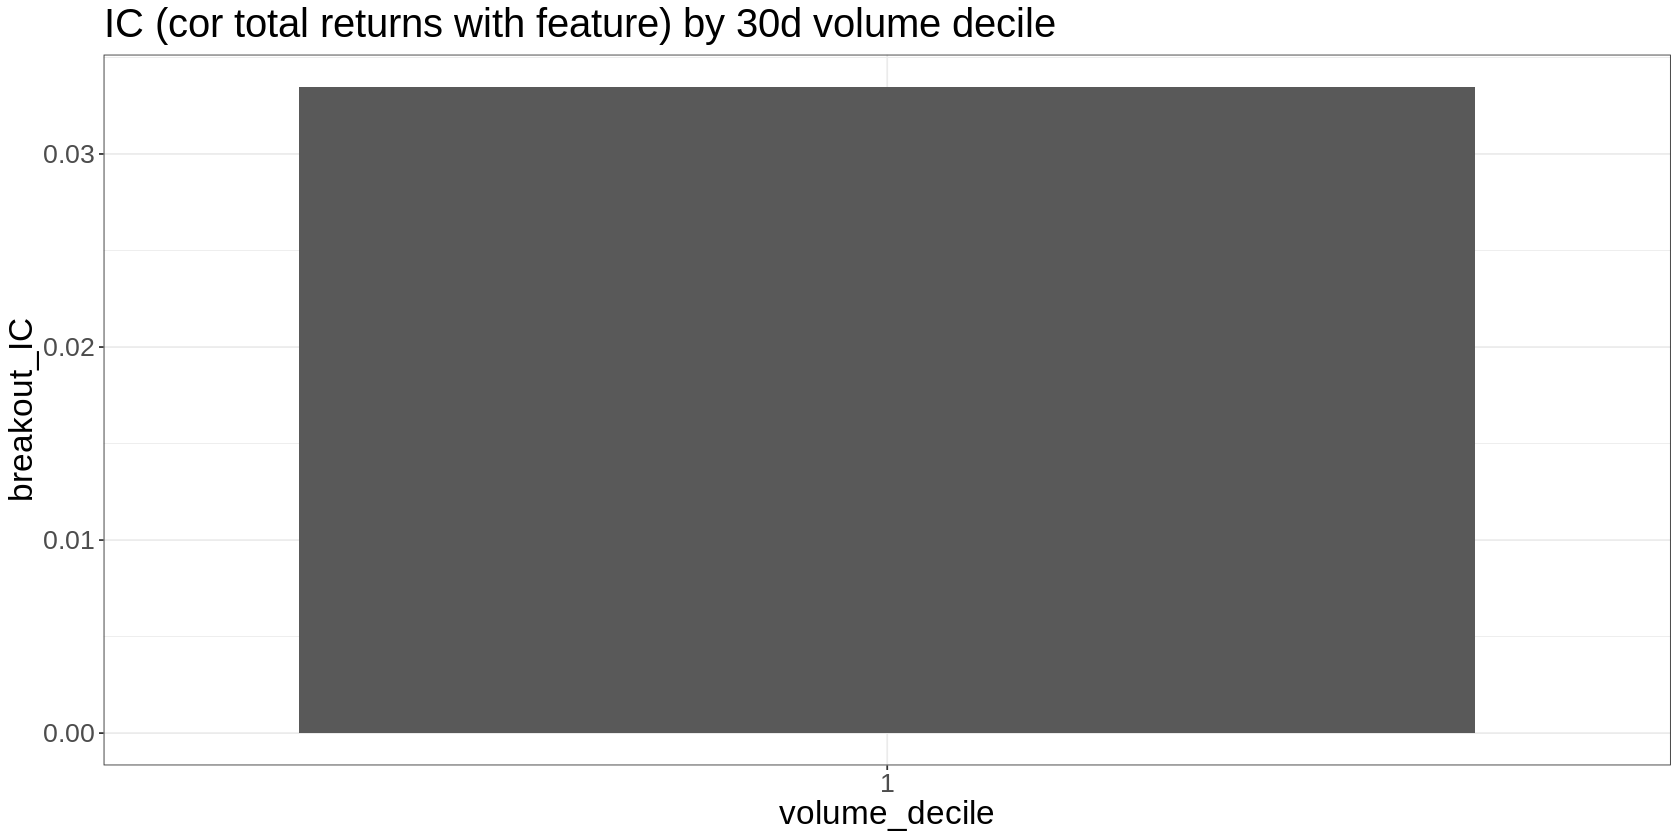

In [15]:
features %>% 
  filter(is_universe, ticker == 'BTC-PERP') %>%
  mutate(volume_decile = factor(ntile(volume30, 10))) %>%
  group_by(volume_decile) %>%
  summarize(breakout_IC = cor(breakout, total_returns_log)) %>%
  ggplot(aes(x=volume_decile, y=breakout_IC)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('IC (cor total returns with feature) by 30d volume decile') 

We see hints of an opposite relationship to what we might expect.

# Shorter term volume 

Now lets look at something that's more likely to be sensible. 

Let's look at volume just as the measurement is taken.... not over the whole range.

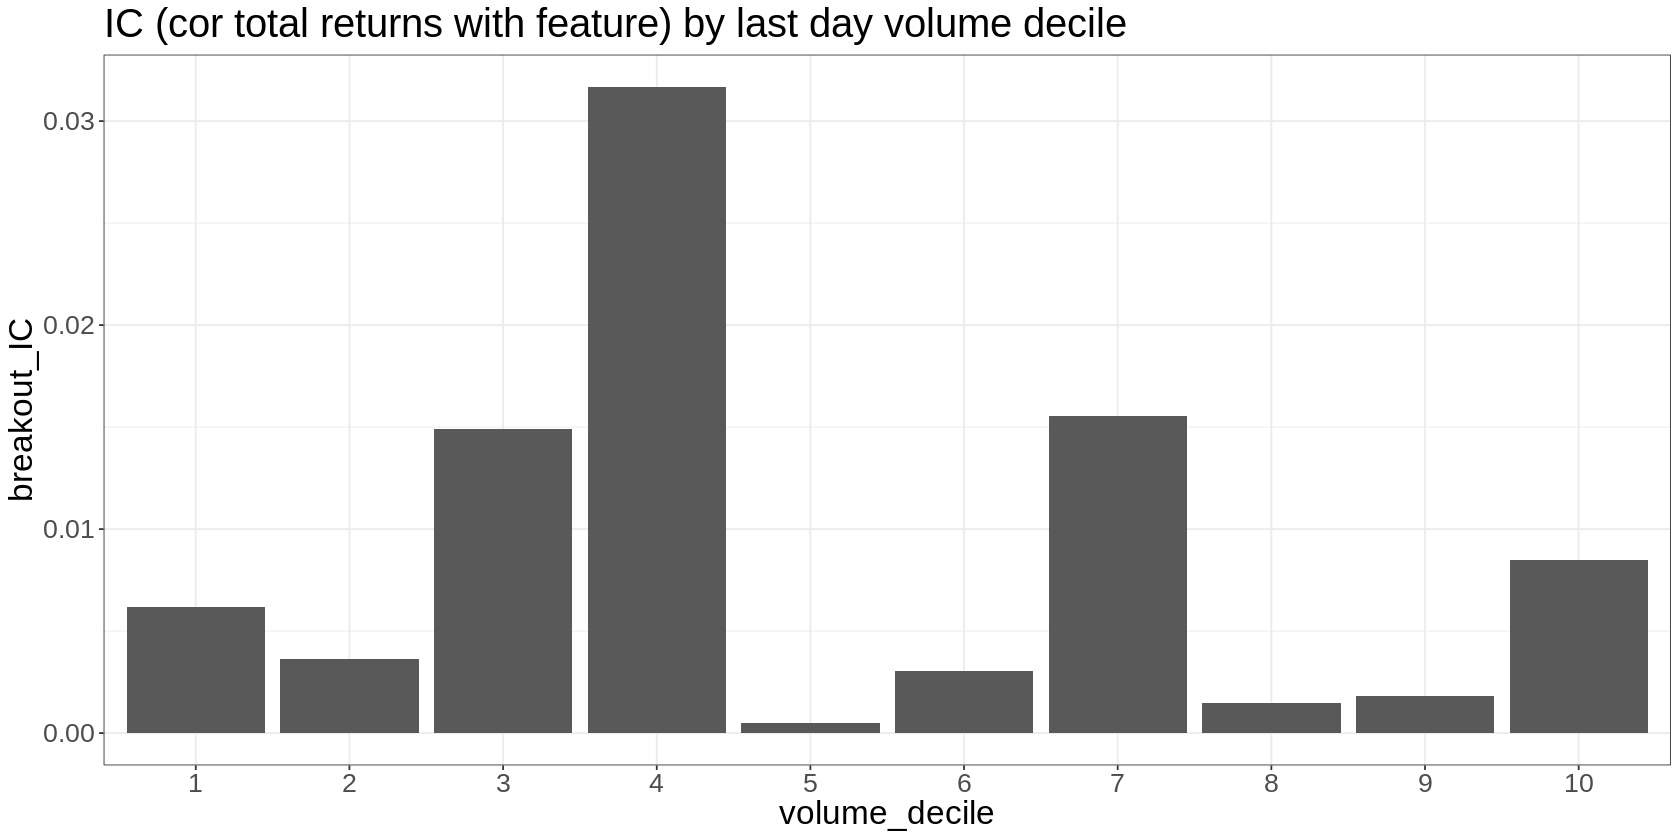

In [16]:
features %>% 
  mutate(year = floor_date(date, 'year')) %>%
  filter(year > '2019-01-01') %>% #hardly any data
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(volume_decile = factor(ntile(volume1, 10))) %>%
  group_by(volume_decile) %>%
  summarize(breakout_IC = cor(breakout, total_returns_log)) %>%
  ggplot(aes(x=volume_decile, y=breakout_IC)) + geom_bar(stat='identity', position = 'dodge') + 
  ggtitle('IC (cor total returns with feature) by last day volume decile')

There we'll basically normalizing volume horizontally each day.

But we've already seen this feature isn't very useful for that. 

So let's instead normalize longitudinally. 

We'll take the zscore of volume over some period, for each ticker. Start with daily volume over a 20 day period.

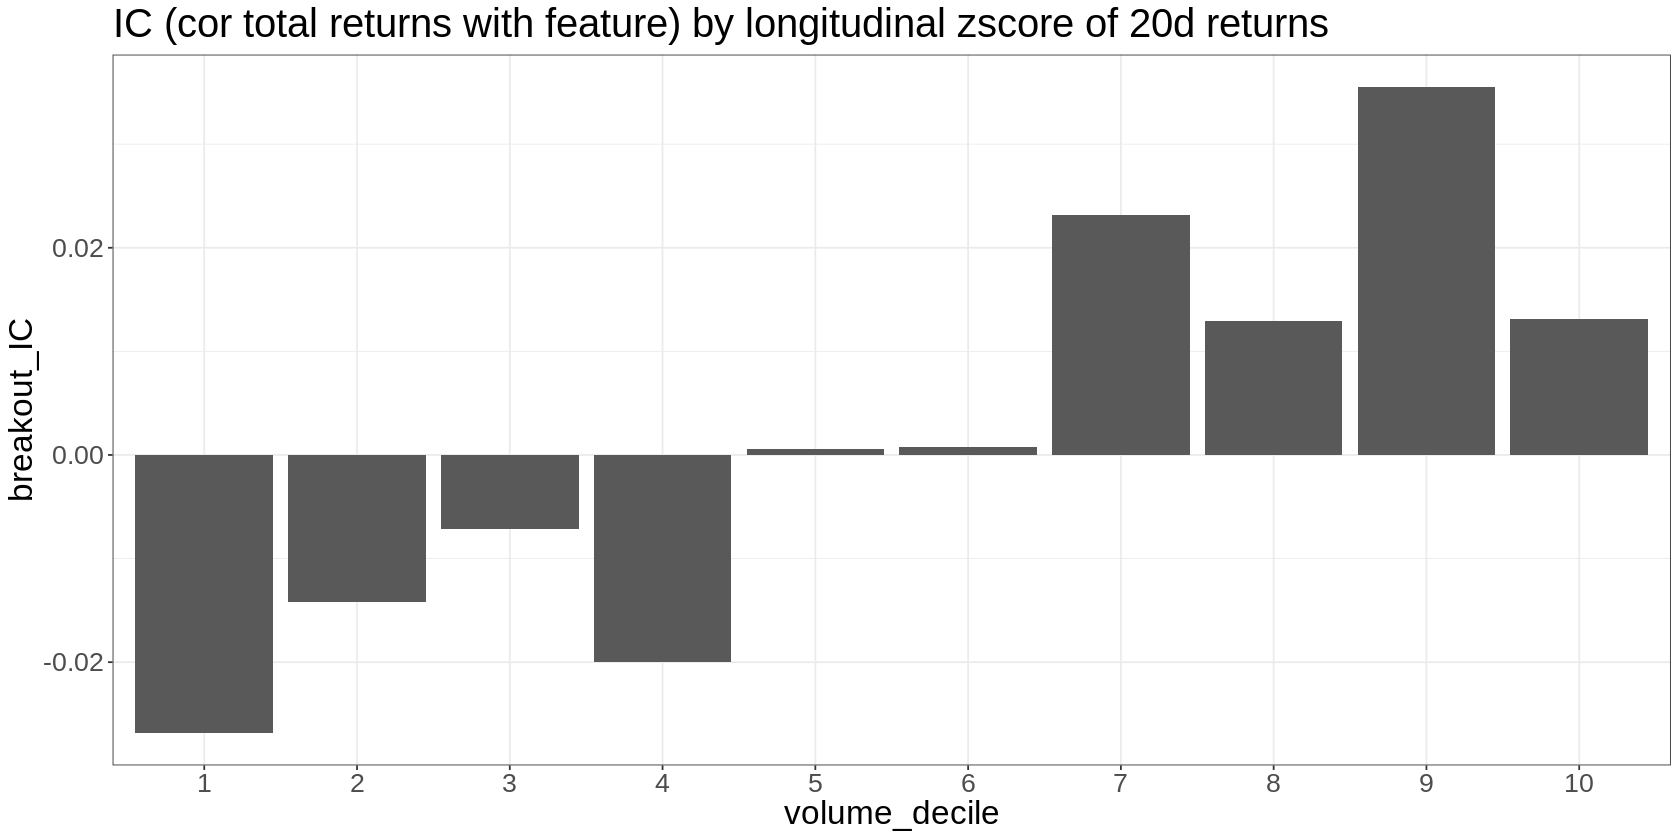

In [17]:
features %>% 
  filter(is_universe) %>%
  ungroup() %>%
  mutate(volume_decile = factor(ntile(volumez20, 10))) %>%
  group_by(volume_decile) %>%
  summarize(breakout_IC = cor(breakout, total_returns_log)) %>%
  ggplot(aes(x=volume_decile, y=breakout_IC)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('IC (cor total returns with feature) by longitudinal zscore of 20d returns')

That's starting to look more like what we'd expect / hope to see.

`summarise()` has grouped output by 'volume_decile'. You can override using the
`.groups` argument.


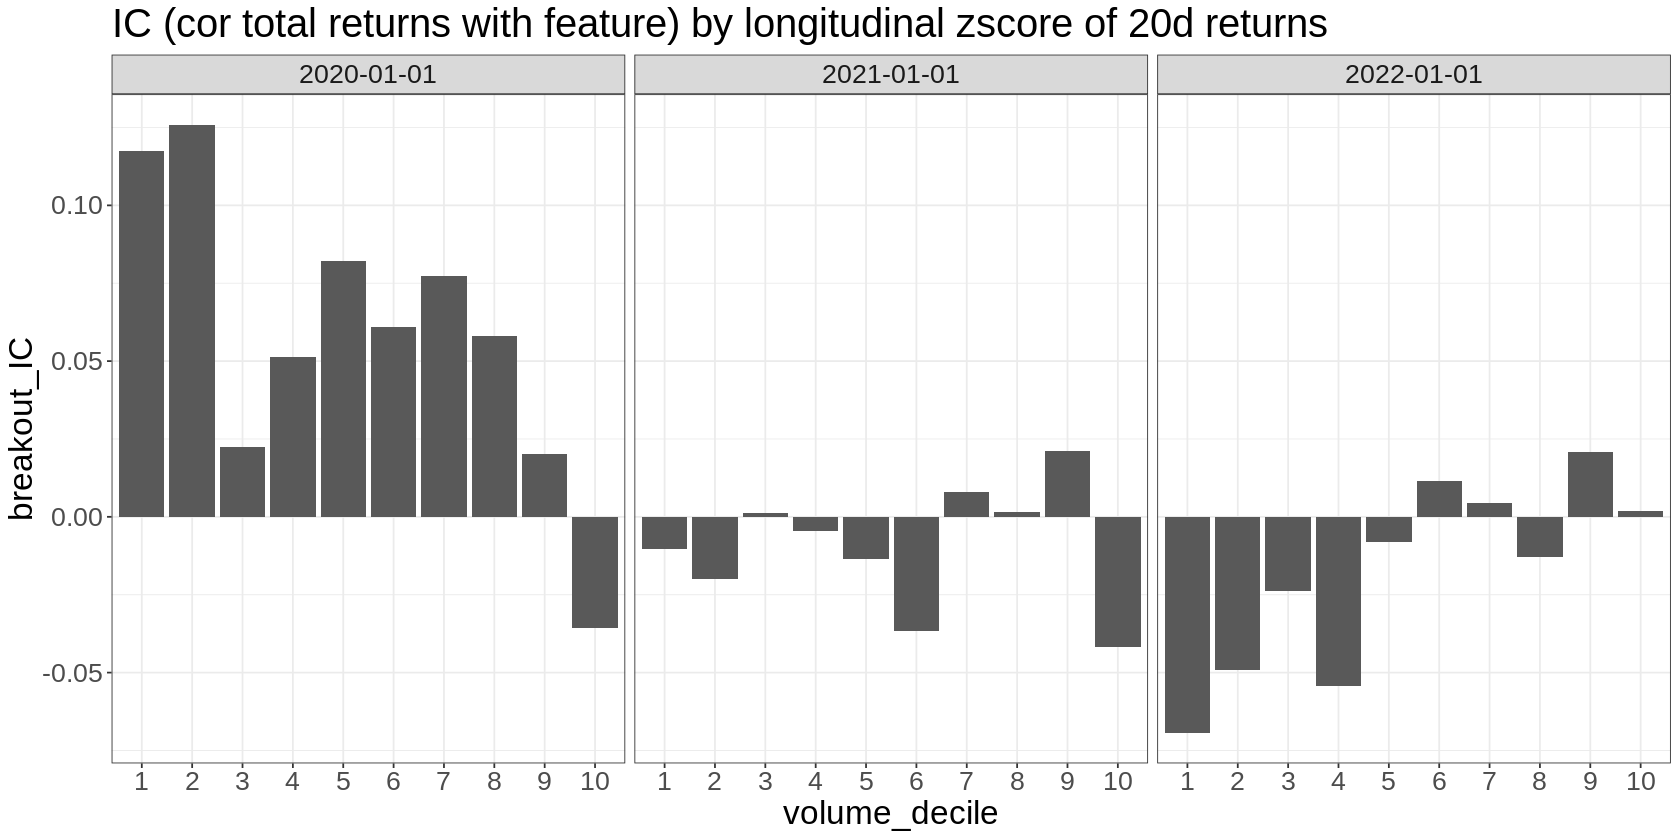

In [18]:
features %>% 
  mutate(year = floor_date(date, 'year')) %>%
  filter(year > '2019-01-01') %>% #hardly any data
  filter(is_universe) %>%
  ungroup() %>%
  mutate(volume_decile = factor(ntile(volumez20, 10))) %>%
  group_by(volume_decile, year) %>%
  summarize(breakout_IC = cor(breakout, total_returns_log)) %>%
  ggplot(aes(x=volume_decile, y=breakout_IC)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('IC (cor total returns with feature) by longitudinal zscore of 20d returns') + 
    facet_wrap(~year)

Interesting, this looks an unusually effective discriminator in 2022.

Let's look at the zscore of 3d average volume vs 20d daily returns (a bit hacky)

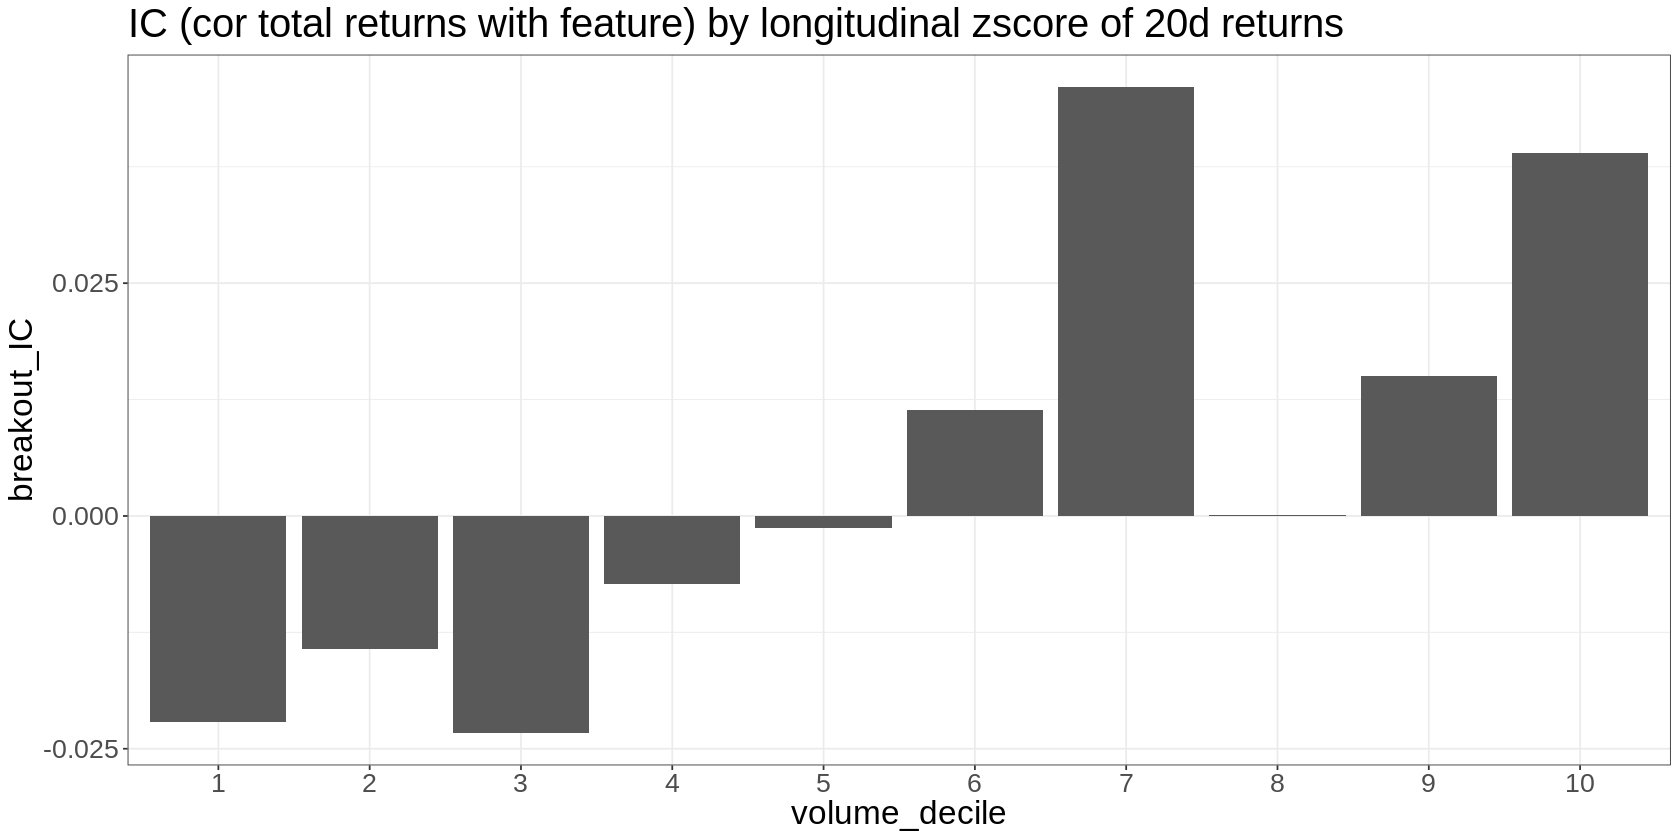

In [19]:
features %>% 
  filter(is_universe) %>%
  ungroup() %>%
  mutate(volume_decile = factor(ntile(volumez3z20, 10))) %>%
  group_by(volume_decile) %>%
  summarize(breakout_IC = cor(breakout, total_returns_log)) %>%
  ggplot(aes(x=volume_decile, y=breakout_IC)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('IC (cor total returns with feature) by longitudinal zscore of 20d returns')

That looks somewhat more effective, perhaps. 

`summarise()` has grouped output by 'volume_decile'. You can override using the
`.groups` argument.


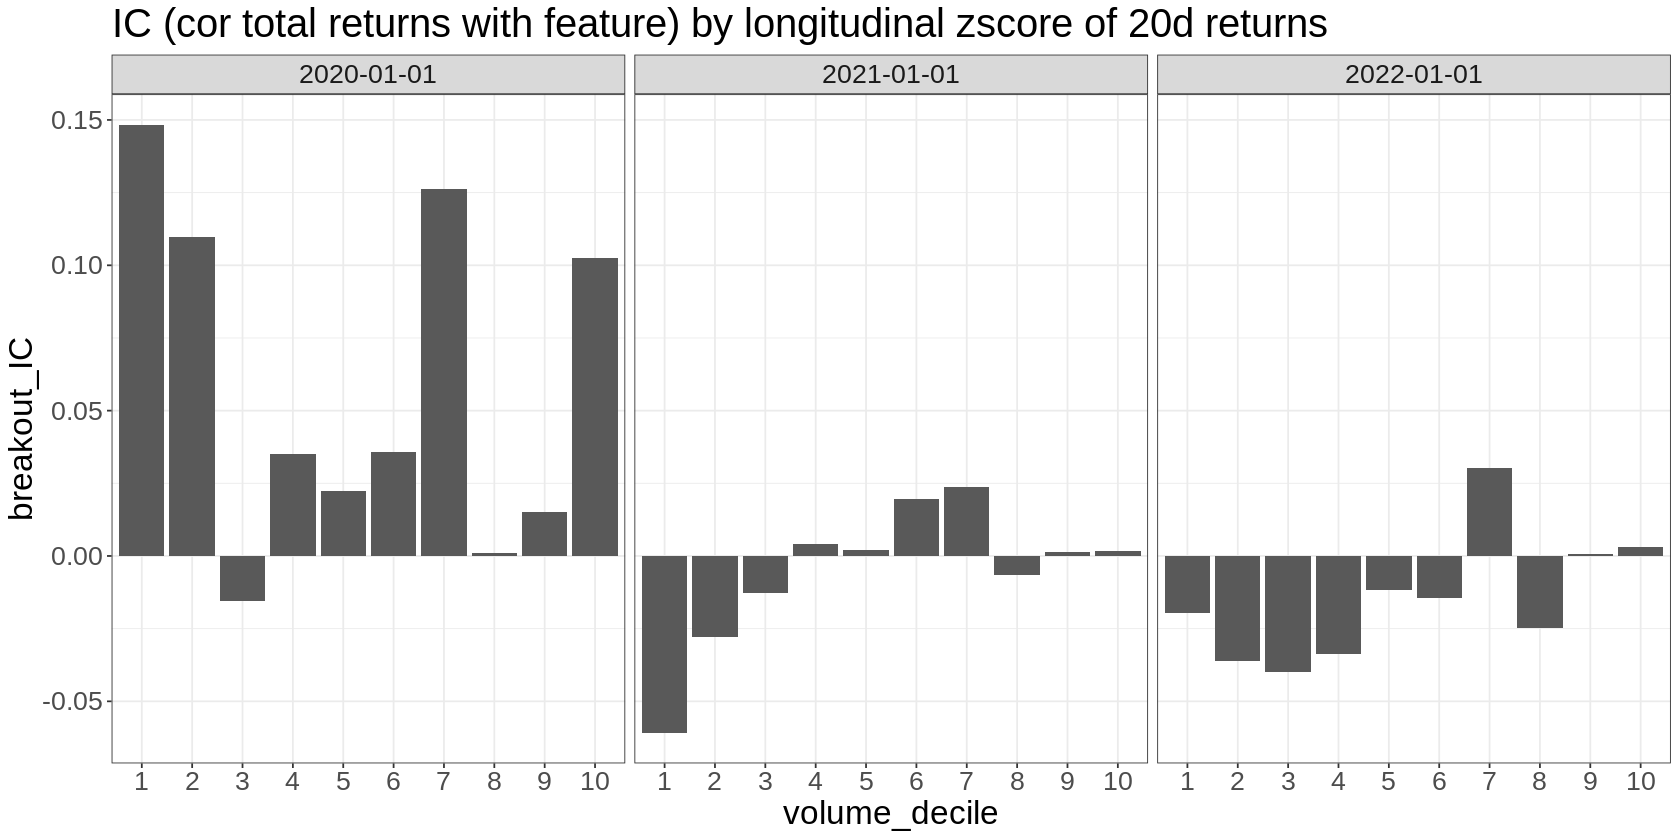

In [20]:
features %>% 
  mutate(year = floor_date(date, 'year')) %>%
  filter(year > '2019-01-01') %>% #hardly any data
  filter(is_universe) %>%
  ungroup() %>%
  mutate(volume_decile = factor(ntile(volumez3z20, 10))) %>%
  group_by(volume_decile, year) %>%
  summarize(breakout_IC = cor(breakout, total_returns_log)) %>%
  ggplot(aes(x=volume_decile, y=breakout_IC)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('IC (cor total returns with feature) by longitudinal zscore of 20d returns') + 
    facet_wrap(~year)

Again looks a bit better behaved.

So - given our features runs from -9.5 to 9.5 - maybe we can multiply it by a volume zscore to get a combined feature?

NOTE: This doesn't quite do what I wanted - it's pretty extreme (two negatives actually makes the signal positive) but it's kinda interesting... 

In [21]:
features %>%
  mutate(vol_breakout = breakout * volumez3z20) %>%
  filter(is_universe) %>%
  ungroup() %>%
  summarize(breakout_IC = cor(vol_breakout, total_returns_log))

breakout_IC
<dbl>
0.01738372


More effective (vs 0.019) than the raw feature at explaining variance.

Let's rank it into 10 buckets and do the factor plot.

`summarise()` has grouped output by 'feature'. You can override using the
`.groups` argument.


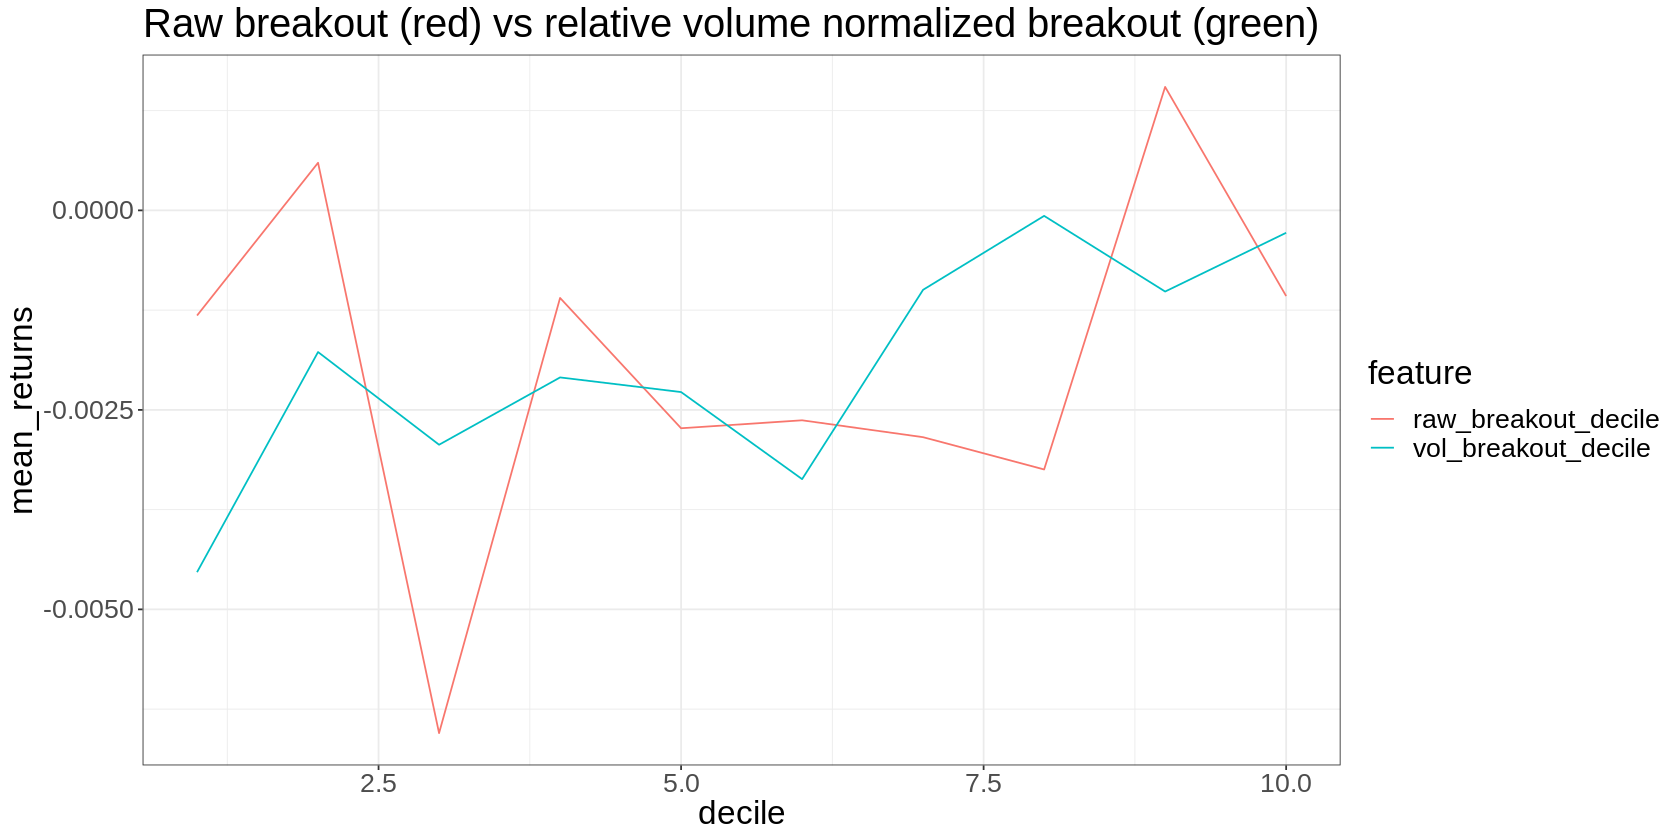

In [22]:
features %>%
  mutate(vol_breakout = breakout * volumez3z20) %>%
  filter(is_universe) %>% 
  ungroup() %>% 
  mutate(
    raw_breakout_decile = ntile(breakout, 10),
    vol_breakout_decile = ntile(vol_breakout, 10)
  ) %>%
  select(raw_breakout_decile, vol_breakout_decile, total_returns_log) %>%
  pivot_longer(c(raw_breakout_decile, vol_breakout_decile), names_to='feature', values_to='decile') %>%
  group_by(feature, decile) %>%
  summarize(mean_returns = mean(total_returns_log)) %>%
  ggplot(aes(x=decile, y=mean_returns, color=feature)) + 
    geom_line() + 
    ggtitle('Raw breakout (red) vs relative volume normalized breakout (green)')

Looks a bit better behaved.

Let's do a dumb simulation of how this would have performed. 

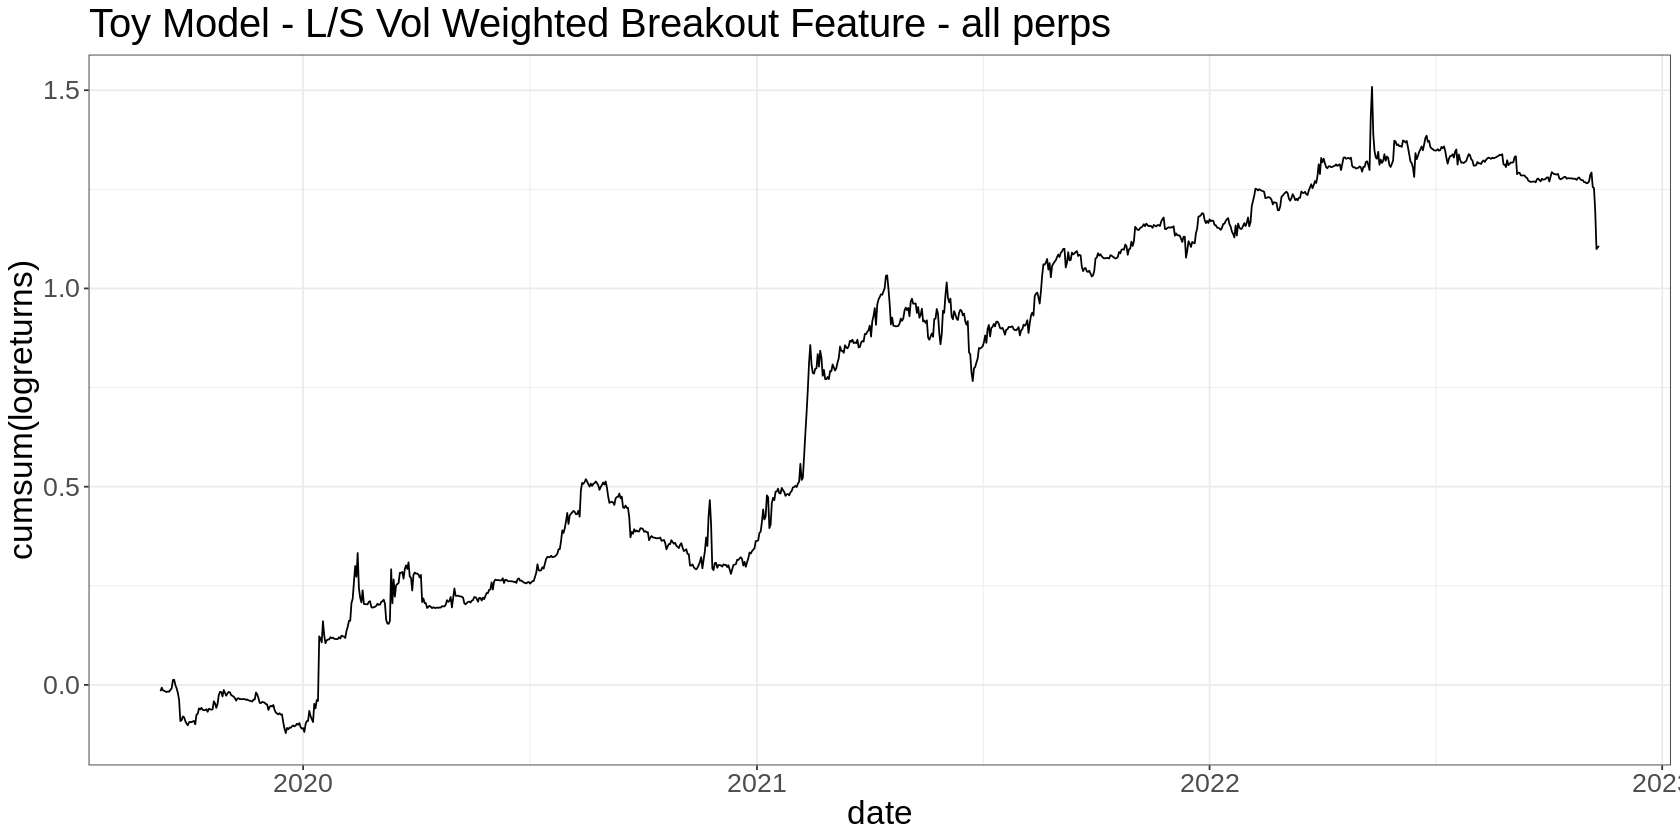

In [23]:
features %>%
  mutate(vol_breakout = breakout * volumez3z20) %>%
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    breakout_weight = breakout / 5 , # Frigged cos breakout runs between -9 and 9
    vol_breakout_weight = vol_breakout / 10
  ) %>%
  na.omit() %>%
  summarize(returns = mean(vol_breakout_weight * total_returns_simple)) %>%
  mutate(logreturns = log(returns+1)) %>%
  ggplot(aes(x=date, y=cumsum(logreturns))) + geom_line() + ggtitle('Toy Model - L/S Vol Weighted Breakout Feature - all perps')

That's better than expected.

Let's compare it to the raw signal.

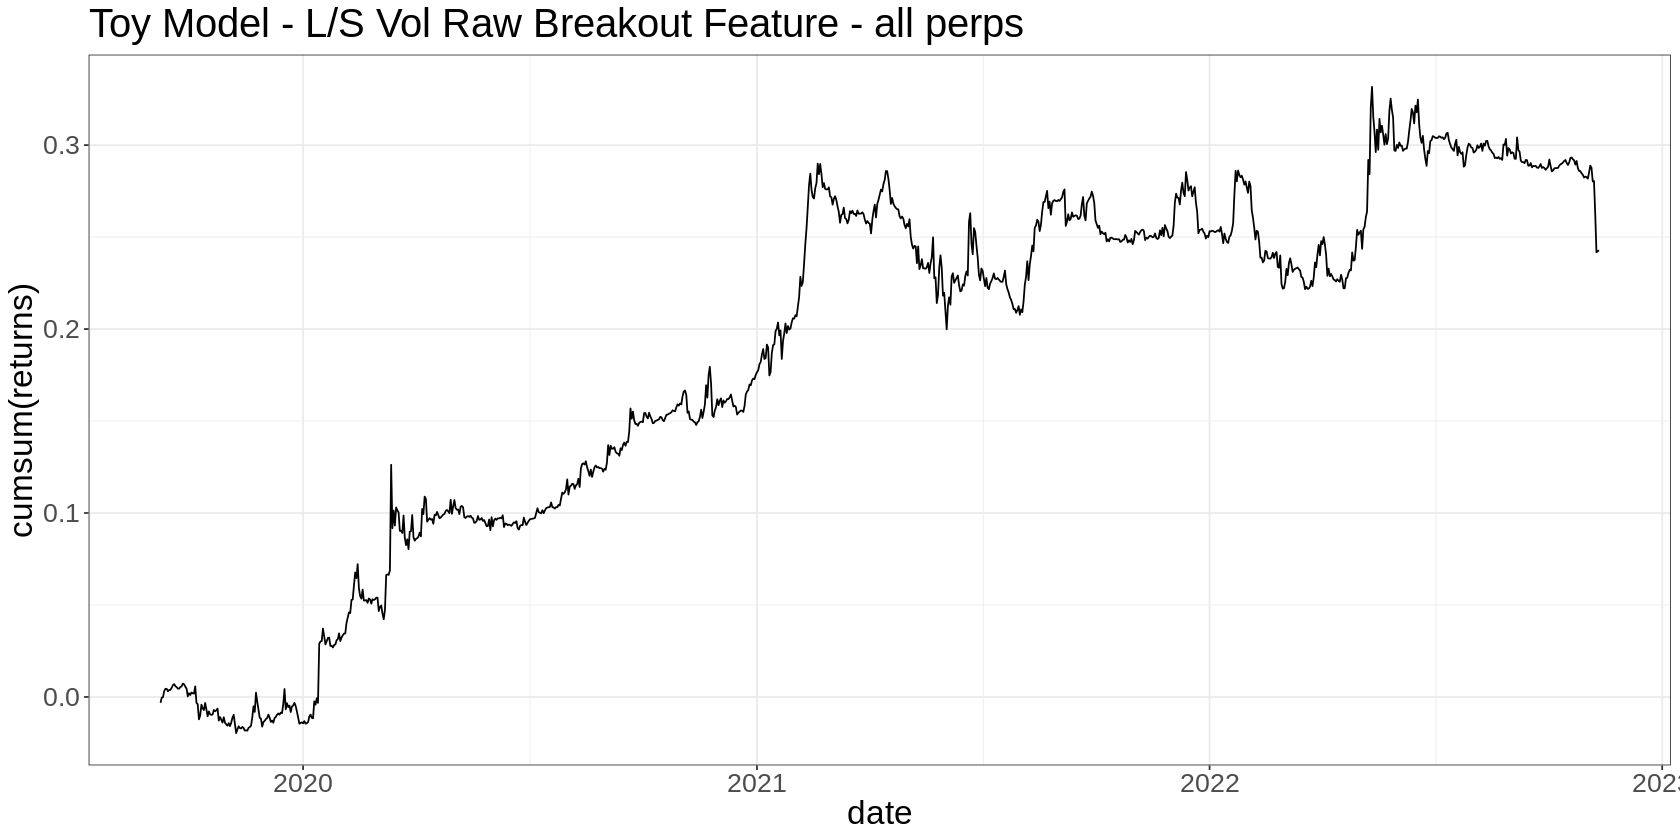

In [24]:
features %>%
  mutate(vol_breakout = breakout * volumez3z20) %>%
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    breakout_weight = breakout / 50 , # Frigged cos breakout runs between -9 and 9
    vol_breakout_weight = vol_breakout / 50
  ) %>%
  na.omit() %>%
  summarize(returns = mean(breakout_weight * total_returns_simple)) %>%
  mutate(logreturns = log(returns+1)) %>%
  ggplot(aes(x=date, y=cumsum(returns))) + geom_line() + ggtitle('Toy Model - L/S Vol Raw Breakout Feature - all perps')

Other approaches are available... We could, for example, just ignore everything that isn't over some volume cutoff.

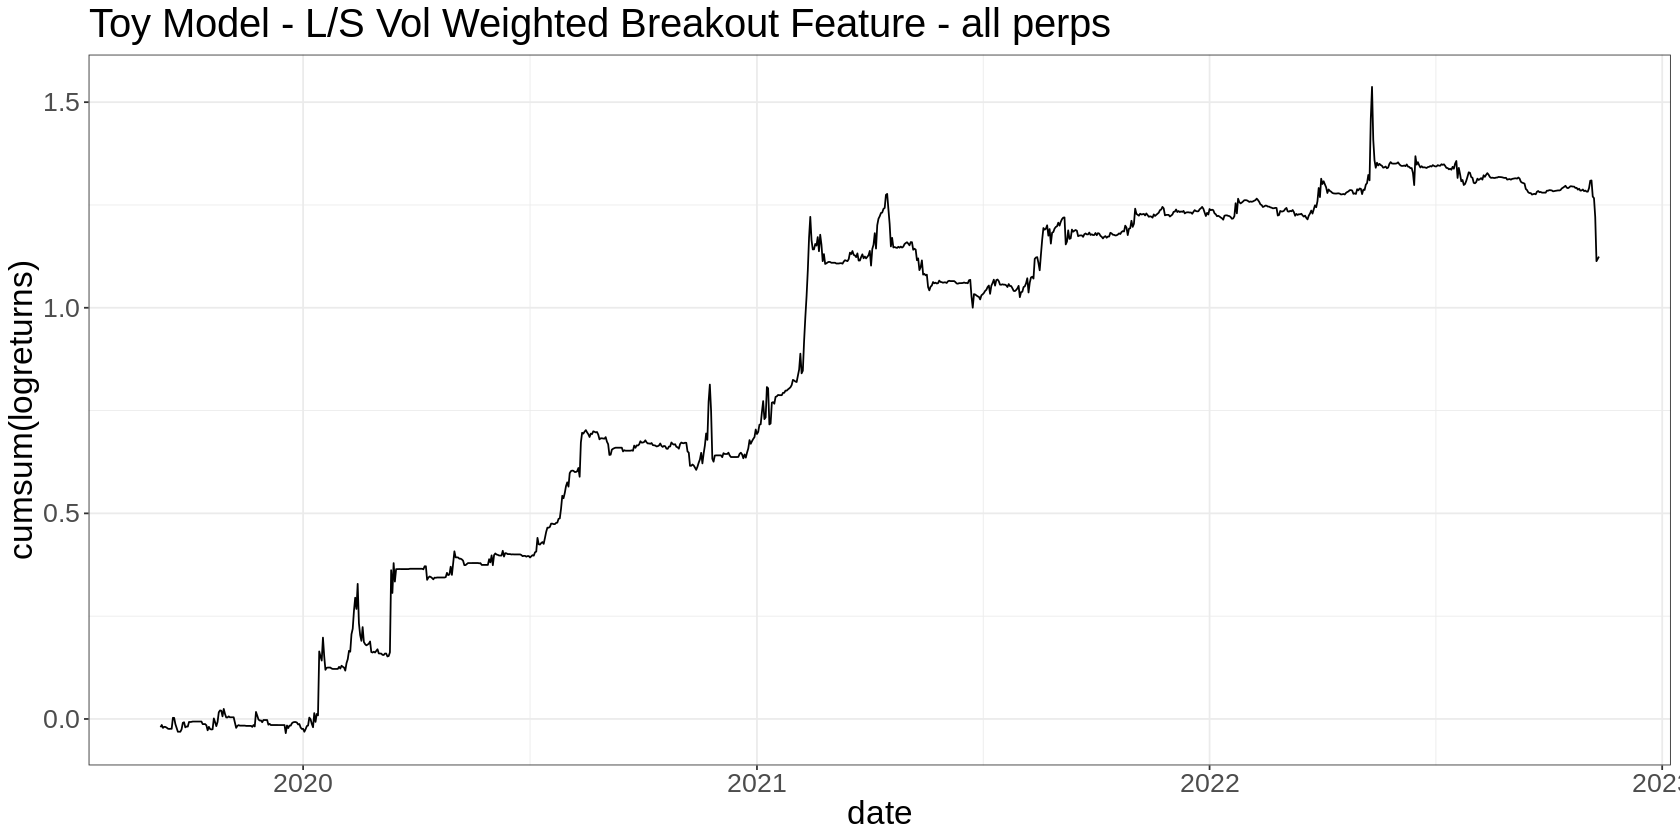

In [25]:
features %>%
  mutate(vol_breakout = breakout * (volumez3z20 > 1)) %>%
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    breakout_weight = breakout / 5 , # Frigged cos breakout runs between -9 and 9
    vol_breakout_weight = vol_breakout / 5
  ) %>%
  na.omit() %>%
  summarize(returns = mean(vol_breakout_weight * total_returns_simple)) %>%
  mutate(logreturns = log(returns+1)) %>%
  ggplot(aes(x=date, y=cumsum(logreturns))) + geom_line() + ggtitle('Toy Model - L/S Vol Weighted Breakout Feature - all perps')

That loooks pretty good too actually. 

Tentatively, i think we might say that volume combined with trend features might be more effective than trend features in isolation. 

# Next Work

Kinda rushed this a bit. Take more time, look at sensitivity etc. 